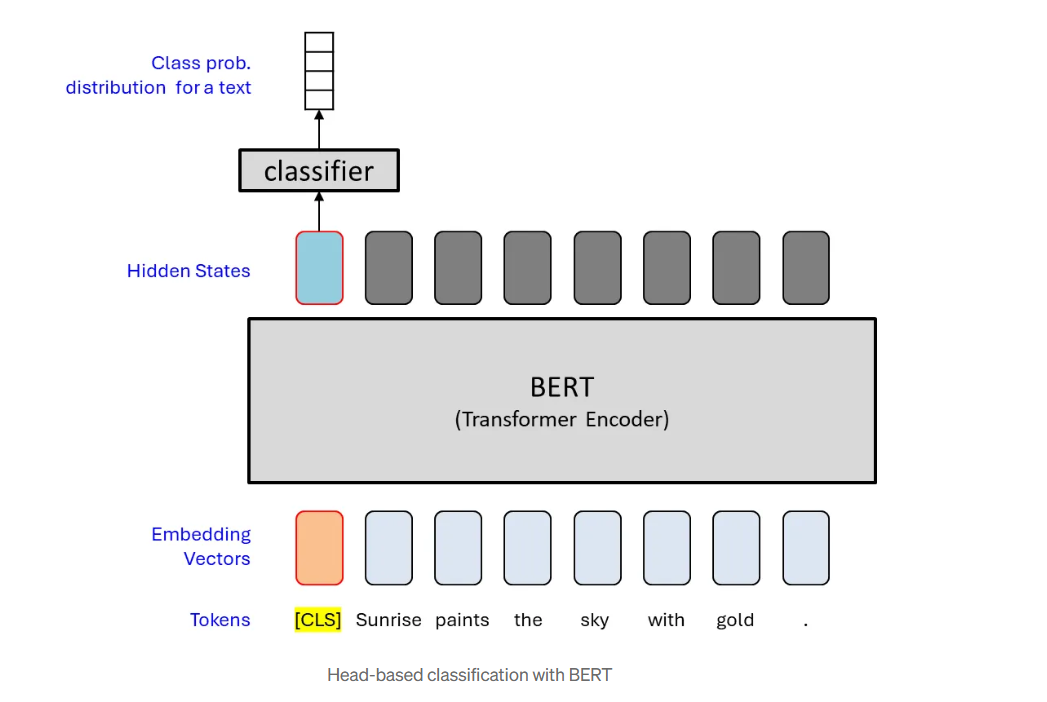

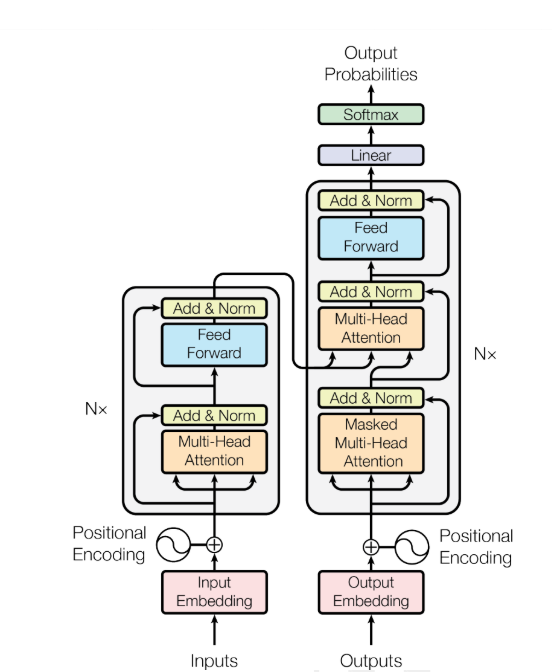

Bert Base Uncased has 110 M Weights and Biase on the other hand 300+ M parameters in BERT base Large

In [ ]:
# Install necessary libraries
!pip install transformers datasets scikit-learn --quiet
!pip install --upgrade  datasets

In [ ]:
# 1. Load IMDB Dataset from HuggingFace Datasets
from datasets import load_dataset
from transformers import EarlyStoppingCallback

dataset = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Split into train and test (take a small subset for fast training)
train_data = dataset["train"].shuffle(seed=42).select(range(5000))
test_data = dataset["test"].shuffle(seed=42).select(range(2000))

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

In [ ]:
train_data = train_data.map(tokenize_function, batched=True)  #batch_size = 500
test_data = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Set format for PyTorch
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Determine how many layers to unfreeze (e.g., last 3 layers)
num_layers_to_unfreeze = 3

In [ ]:
# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Unfreeze the classifier head
for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
# Unfreeze the last 'num_layers_to_unfreeze' encoder layers
for i in range(1, num_layers_to_unfreeze + 1):
    for param in model.bert.encoder.layer[-i].parameters():
        param.requires_grad = True

In [ ]:
# 4. Define Metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [ ]:
# 5. Define Trainer
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./bert_sentiment_partial",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to = "none"  #to disable WandB integration

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 6. Train the Model
trainer.train()

# 7. Evaluate
results = trainer.evaluate()
print("\nFinal Evaluation Results:")
for key, value in results.items():
    print(f"{key.capitalize()}: {value:.4f}")

<ipython-input-13-1564853996>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.354100,0.282483,0.887000,0.832474,0.969000,0.895564
2,0.235700,0.278392,0.916000,0.901544,0.934000,0.917485
3,0.177500,0.274199,0.923000,0.916339,0.931000,0.923611



Final Evaluation Results:
Eval_loss: 0.2742
Eval_accuracy: 0.9230
Eval_precision: 0.9163
Eval_recall: 0.9310
Eval_f1: 0.9236
Eval_runtime: 56.9921
Eval_samples_per_second: 35.0930
Eval_steps_per_second: 4.3870
Epoch: 3.0000


In [ ]:
trainer.save_model("/content/bert_sentiment_model_last3")
tokenizer.save_pretrained("/content/bert_sentiment_model_last3")

('/content/bert_sentiment_model_last3/tokenizer_config.json',
 '/content/bert_sentiment_model_last3/special_tokens_map.json',
 '/content/bert_sentiment_model_last3/vocab.txt',
 '/content/bert_sentiment_model_last3/added_tokens.json')

In [ ]:
from google.colab import files

# Download the saved model and tokenizer directories
!zip -r /content/bert_sentiment_model_last3.zip /content/bert_sentiment_model_last3
files.download('/content/bert_sentiment_model_last3.zip')

  adding: content/bert_sentiment_model_last3/ (stored 0%)
  adding: content/bert_sentiment_model_last3/special_tokens_map.json (deflated 42%)
  adding: content/bert_sentiment_model_last3/training_args.bin (deflated 52%)
  adding: content/bert_sentiment_model_last3/vocab.txt (deflated 53%)
  adding: content/bert_sentiment_model_last3/model.safetensors (deflated 7%)
  adding: content/bert_sentiment_model_last3/tokenizer_config.json (deflated 75%)
  adding: content/bert_sentiment_model_last3/config.json (deflated 49%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip -o /content/bert_sentiment_model_last3.zip -d /content/

# Load the model and tokenizer from the extracted directory
loaded_tokenizer = BertTokenizer.from_pretrained("/content/content/bert_sentiment_model_last3")
loaded_model = BertForSequenceClassification.from_pretrained("/content/content/bert_sentiment_model_last3")

print("Model and tokenizer loaded successfully from the zip archive.")

Archive:  /content/bert_sentiment_model_last3.zip
   creating: /content/content/bert_sentiment_model_last3/
  inflating: /content/content/bert_sentiment_model_last3/special_tokens_map.json  
  inflating: /content/content/bert_sentiment_model_last3/training_args.bin  
  inflating: /content/content/bert_sentiment_model_last3/vocab.txt  
  inflating: /content/content/bert_sentiment_model_last3/model.safetensors  
  inflating: /content/content/bert_sentiment_model_last3/tokenizer_config.json  
  inflating: /content/content/bert_sentiment_model_last3/config.json  
Model and tokenizer loaded successfully from the zip archive.


In [ ]:
rotten_tomatoes_dataset = load_dataset("rotten_tomatoes", split="test")

# Take the first 500 reviews
rotten_tomatoes_subset = rotten_tomatoes_dataset.select(range(500))

# 2. Preprocess the Rotten Tomatoes subset: Tokenization
# Use the loaded tokenizer
def tokenize_function_rt(examples):
    return loaded_tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

rotten_tomatoes_subset_tokenized = rotten_tomatoes_subset.map(tokenize_function_rt, batched=True)

# Set format for PyTorch
rotten_tomatoes_subset_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# 3. Define a Trainer for evaluation using the loaded model
# We only need an evaluation trainer here
rt_eval_trainer = Trainer(
    model=loaded_model,
    args=TrainingArguments(
        output_dir="./rt_evaluation", # Output directory is needed even for evaluation
        per_device_eval_batch_size=8,
        report_to = "none",
    ),
    eval_dataset=rotten_tomatoes_subset_tokenized,
    compute_metrics=compute_metrics, # Use the same compute_metrics function
    tokenizer=loaded_tokenizer,
)

# 4. Evaluate the loaded model on the Rotten Tomatoes subset
print("\nEvaluating on the first 500 Rotten Tomatoes reviews:")
rt_results = rt_eval_trainer.evaluate()

# Print the evaluation results
print("\nRotten Tomatoes Subset Evaluation Results (first 500 reviews):")
for key, value in rt_results.items():
    print(f"{key.capitalize()}: {value:.4f}")

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<ipython-input-18-2340089485>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  rt_eval_trainer = Trainer(



Evaluating on the first 500 Rotten Tomatoes reviews:



Rotten Tomatoes Subset Evaluation Results (first 500 reviews):
Eval_loss: 0.4057
Eval_model_preparation_time: 0.0025
Eval_accuracy: 0.8860
Eval_precision: 1.0000
Eval_recall: 0.8860
Eval_f1: 0.9396
Eval_runtime: 14.2333
Eval_samples_per_second: 35.1290
Eval_steps_per_second: 4.4260


In [ ]:
import pandas as pd
import torch

# Get predictions for the Rotten Tomatoes subset
predictions_output = rt_eval_trainer.predict(rotten_tomatoes_subset_tokenized)
predictions = predictions_output.predictions
predicted_labels = torch.argmax(torch.tensor(predictions), dim=1).tolist()
actual_labels = rotten_tomatoes_subset["label"]

# Create the DataFrame
eval_df = pd.DataFrame({
    'text': rotten_tomatoes_subset["text"],
    'prediction': predicted_labels,
    'actual': actual_labels
})

print(eval_df.head())

                                                text  prediction  actual
0  lovingly photographed in the manner of a golde...           1       1
1              consistently clever and suspenseful .           1       1
2  it's like a " big chill " reunion of the baade...           1       1
3  the story gives ample opportunity for large-sc...           1       1
4                  red dragon " never cuts corners .           1       1
